# Sanity check for simplifying assumptions taken
This is a notebook to check if the simplifying assumptions can be justified or if any counter measures should be taken in order to make the model more realistic

In [1]:
# import packages
import pandas as pd
import os
from edisgo.edisgo import import_edisgo_from_files

c:\users\anya.heider\appdata\local\continuum\miniconda3\envs\edisgo_env\lib\site-packages\sqlalchemy\ext\declarative\base.py:436: SAWarning: Ignoring declarative-like tuple value of attribute 'segment': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?
  "accidentally placed at the end of the line?" % k
c:\users\anya.heider\appdata\local\continuum\miniconda3\envs\edisgo_env\lib\site-packages\sqlalchemy\ext\declarative\base.py:436: SAWarning: Ignoring declarative-like tuple value of attribute 'cable': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?
  "accidentally placed at the end of the line?" % k


## Power flow
Check if linearisation of power flow holds

Pay special attention to:
- Bus voltages and line loading: Are they in a tolerable range within the AC values?
- Power factor: Should this be determined per node?
- Curtailment: Does this make any sense or do we have to adapt the approach?

In [2]:
results_dir = 'grid_data/test_run/'
grid_id = 1056

edisgo_dir = r'\\192.168.10.221\Daten_flexibel_02\simbev_results\eDisGo_object_files_final\Electrification_2050\{}\reduced'.format(grid_id)#Todo: change back to final in the end


In [3]:
# run AC power flow calculation for comparison
edisgo_obj = import_edisgo_from_files(edisgo_dir, import_timeseries=True)
edisgo_obj.analyze(mode='mvlv')

C:\Users\Anya.Heider\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
C:\Users\Anya.Heider\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:6701: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2011-01-08 00:00:00', '2011-01-08 00:15:00',
               '2011-01-08 00:30:00', '2011-01-08 00:45:00',
               '2011-01

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.059933 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.058430 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031249 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046792 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.045400 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046901 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053391 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046902 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.048191 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031279 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046832 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053439 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.048237 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.051877 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.058419 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.058899 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.051942 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046864 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.056899 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066240 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.100257 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084612 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.067901 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.085506 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.078028 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053341 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066170 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.087129 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084615 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068867 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.040311 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.059924 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046868 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053439 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046903 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037813 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046862 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.049073 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.057584 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.045754 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.043638 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.056439 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046868 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046900 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046869 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053246 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.044341 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.055937 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046899 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037779 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.050845 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.041754 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.056900 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.043291 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046887 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046908 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053440 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046896 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053339 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046903 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031249 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.047754 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046900 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031280 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031244 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037792 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.048219 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031278 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046885 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037792 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053737 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053667 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.049923 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046900 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046891 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053401 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.049145 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.050801 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046868 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053433 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046861 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037550 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.047260 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.036323 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046901 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037784 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046900 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037782 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046899 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037790 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046791 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046899 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046865 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046900 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046876 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046903 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046861 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046900 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046884 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.034476 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.049925 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.057580 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.050042 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.048213 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.048033 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046867 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.096846 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037751 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062520 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037583 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.062482 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053016 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069003 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062484 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053391 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053367 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052065 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066436 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.065997 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062491 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.058881 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.052651 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.047403 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.048255 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.051876 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000001 in 0.046864 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053379 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031246 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.048876 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046863 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.056206 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046867 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.033268 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031244 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037747 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052634 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.047377 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046867 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053370 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046864 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.032600 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.036253 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046870 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037750 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046868 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037600 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046867 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.045126 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046867 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.061467 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

In [53]:
# import results of optimisation and compare
v_opt = pd.read_csv(results_dir+'bus_voltage_0.csv', index_col=0, parse_dates=True)/edisgo_obj.topology.mv_grid.nominal_voltage
line_active = pd.read_csv(results_dir+'line_active_power_0.csv', index_col=0, parse_dates=True)
line_reactive = pd.read_csv(results_dir+'line_reactive_power_0.csv', index_col=0, parse_dates=True)

In [54]:
v_ref = edisgo_obj.results.v_res
line_active_ref = edisgo_obj.results.pfa_p
line_reactive_ref = edisgo_obj.results.pfa_q

(0.33371195448790303, -0.06417072317331796, 0.03986780237644671)

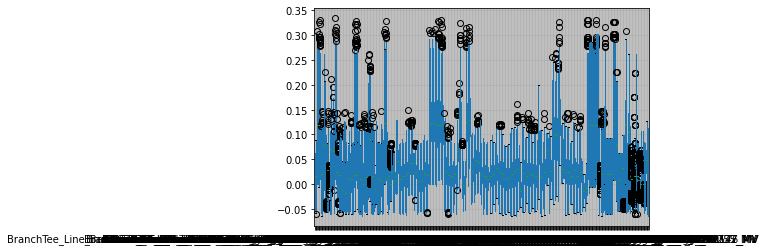

In [55]:
# maximum difference voltage
diff_v_percent = (v_opt-v_ref)*100
diff_v_percent.boxplot()
diff_v_percent.max().max(), diff_v_percent.min().min(), diff_v_percent.mean().mean()

In [60]:
# maximum difference active_power
diff_active = line_active.abs()-line_active_ref.abs()
diff_active.dropna(how='all', inplace=True)
diff_active.dropna(how='all', axis=1, inplace=True)
diff_active.max().max(), diff_active.min().min(), diff_active.mean().mean()

(0.05902744903126189, -0.12523249387973934, -0.002242377795186283)

In [61]:
diff_active.min().idxmin()
time_stamp = pd.to_datetime('2011-01-14 09:15:00')
branch = 'Branch_LVStation_mvgd_1056_lvgd_97723_MVStation_mvgd_1056'
diff_active.loc[time_stamp, branch], line_active.loc[time_stamp, branch], line_active_ref.loc[time_stamp, branch]

(-0.07319473750578354, -3.404, 3.4771947375057835)

In [62]:
# maximum difference active_power
diff_reactive = line_reactive.abs()-line_reactive_ref.abs()
diff_reactive.dropna(how='all', inplace=True)
diff_reactive.dropna(how='all', axis=1, inplace=True)
diff_reactive.max().max(), diff_reactive.min().min(), diff_reactive.mean().mean()

(0.0003968487136348786, -0.320309508040268, -0.008432970251000657)

<AxesSubplot:>

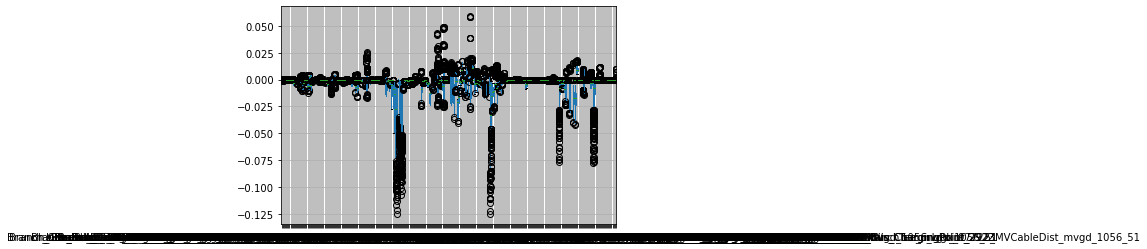

In [63]:
diff_active.boxplot()

In [65]:
# check curtailment
active_curtailment_feedin = pd.read_csv(results_dir+'curtailment_feedin_0.csv', index_col=0, parse_dates=True)
active_curtailment_load = pd.read_csv(results_dir+'curtailment_load_0.csv', index_col=0, parse_dates=True)
reactive_curtailment_feedin = pd.read_csv(results_dir+'curtailment_reactive_feedin_0.csv', index_col=0, parse_dates=True)
reactive_curtailment_load = pd.read_csv(results_dir+'curtailment_reactive_load_0.csv', index_col=0, parse_dates=True)
active_curtailment_feedin.sum().sum(), active_curtailment_load.sum().sum(), reactive_curtailment_feedin.sum().sum(), reactive_curtailment_load.sum().sum()

(0.0, 0.0, 0.0, 0.0)

## Curtailment
Check whether optimised curtailment and iterative approach yield roughly the same results.

Proceeding:
- Run optimisation of small unit with curtailment
- Run heuristic after applying the optimised time series
- Check how much results deviate 
- Find possible reasons